In [1]:
import dolfinx
import gmsh
import tqdm
import copy
import cmasher
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.ndimage import uniform_filter1d, gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.tri as mtri
import matplotlib.colors
import matplotlib.animation
import matplotlib.cm as cm

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)

from mpi4py import MPI
from Source_pf.Mesh import *
from Source_pf.Simulation import *
from Source_pf.VideoController import *

--------------------------------------------------------------------------

  Local host:   node1191
  Local device: mlx5_0
--------------------------------------------------------------------------


OSError: /lib64/libm.so.6: version `GLIBC_2.23' not found (required by /home/davidgoh/miniforge3/envs/fenics/lib/libgmsh.so.4.11)

In [3]:
rnaprofile = lambda x: 0.277384 - 0.00156433*x - 0.0146816*x**2 - 0.00317079*x**3 + 0.00204666*x**4 - 0.000344679*x**5 + 2.58265e-5*x**6 - 5.86922e-7*x**7 - 3.73715e-8*x**8 + 2.6403e-9*x**9 - 4.8109e-11*x**10

In [4]:
L_grad   = 5
L_domain = 7
domain_parameters = DomainParameters(L = L_domain, dim=2)
mesh = Mesh(
    MPI.COMM_SELF,
    domain_parameters
)

parameters = Parameters(M=1000.0, dt=1.0e-2, x0=-5.0, χ=-0.01, c_out = 0.1)
simulation = Simulation(MPI.COMM_SELF, mesh, parameters)

# assign values to m in lab frame
x = simulation.m.function_space.tabulate_dof_coordinates()
r = np.linalg.norm(x, axis=1)
# simulation.m.x.array[:] = np.exp(-(r/L_grad)**2 ) / (1+(r/L_grad))
simulation.m.x.array[:] = rnaprofile(r)

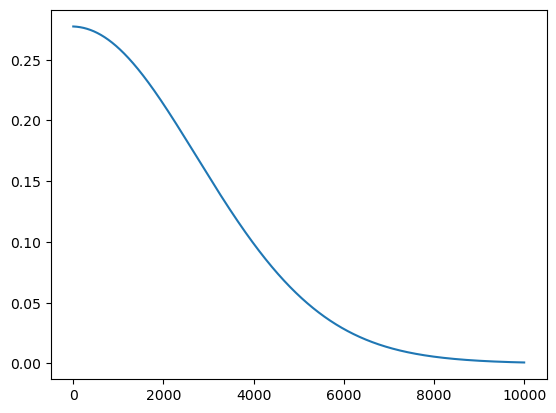

In [14]:
arr = np.linspace(0,10,10000)
plt.plot(rnaprofile(arr))

In [18]:
# set up pandas dataframe to store data
data = pd.DataFrame()

# set up callback function to get data
def get_data():
    # make measurement
    tmp = pd.DataFrame([{
            "t": simulation.now.time,
            "x": simulation.get_position(),
            "V": simulation.get_volume(),
            "mass": simulation.get_total_mass(),
            "grad_m": simulation.get_gradient_m(),
            "grad_mu": simulation.get_chemical_potential_imbalance()
        }])

    # assign to global pandas dataframe
    global data
    data = pd.concat([data, tmp], ignore_index=True)
    
simulation.run(5.0, max_timestep=0.1, callbacks=[get_data])

100%|██████████| 5.0/5.0 [1:36:03<00:00, 1152.61s/it]               


  pairs_cmap = cm.get_cmap('Paired')



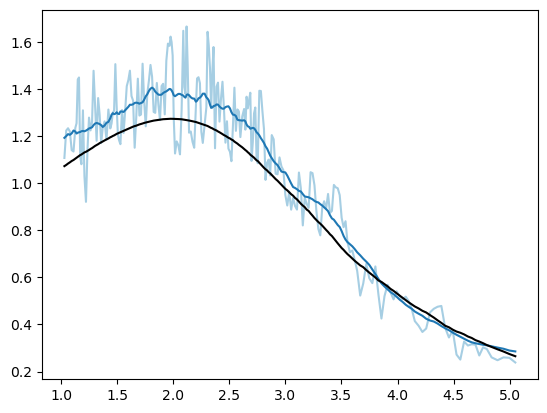

In [52]:
pairs_cmap = cm.get_cmap('Paired')
plt.plot(data.t, np.gradient(data.x,data.t),color=pairs_cmap(0))
plt.plot(data.t, uniform_filter1d(np.gradient(data.x,data.t),30),color=pairs_cmap(1))
plt.plot(data.t, -domain_parameters.dim * parameters.M * parameters.χ / ((c_in - parameters.c_out) * data.V) * data.grad_m, color="black")